In [ ]:
import numpy as np
# feature extracture (mfcc) + load wave files
import librosa
# walking on the wave files with different names
import os 
from tqdm import tqdm_notebook as tqdm
# to save and load variables
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
from IPython import display
# Model
import tensorflow as tf
import tensorflow.keras
from tensorflow import keras
from tensorflow.keras import layers, models, activations, optimizers, losses
from keras.models import Model
# Machine learning tools for performance comparison
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
#setting
matplotlib.rcParams['figure.figsize'] = (6, 2)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
# getting the name of files without extention
# os.path.splitext(os.path.basename('/content/DR1FCJF0SA1.WAV'))[0]

In [ ]:
#useing to load dataset
loadProccedData = True

In [ ]:
# download TIMIT DB
if loadProccedData == False:
  !wget cls.ru.nl/~ltenbosch/TIMIT.tar.gz

In [ ]:
# unzip files
if loadProccedData == False:
  !tar -zxvf /content/TIMIT.tar.gz

In [ ]:
#calculating the energy of wav files
def energy(wav):
  energ = np.inner(wav, wav)
  return energ
#Normalyzing the wav files
def normaliz(wav):
  wav /= energy(wav)
  return wav

In [ ]:
# train set (feature extracting from wav and phonetics from text files)
if loadProccedData == False:
  trainPhonesFeatures = []
  trainPhonesLabels = []
  trainDialectRegion = []
  trainSpeakerID = []
  # counterCheck = 0
  pathBase = '/content/wavfiles16kHz/TRAIN/'
  # walking on all files
  for path in tqdm(os.listdir(pathBase)):
    # counterCheck += 1
    # if counterCheck == 10 :
    #   break
    wavFile, sampleRate = librosa.load(pathBase+path)
    sampleRate = 16000
    #Normilizing wav file to its energy
    wavFile = normaliz(wavFile)
    # extracting features 
    wavMfccFeatures = librosa.feature.mfcc(y=wavFile, sr=sampleRate,
                                           n_mfcc=13, hop_length=160)
    # print(len(wavFile)/sampleRate * 100)
    # print(np.shape(wavMfccFeatures))
    
    
    # path of text files (.PHN)
    pathToPhn = '/content/PHN/TRAIN/' + os.path.splitext(os.path.basename(path))[0] + '.PHN'
    dialectRegion = path[0 : 3]
    speakerID = path[3 : 8]

    with open(pathToPhn) as f:
      line = f.readline()
      while line:
        start, end, phoneName = line.split(sep=' ')
        trainPhonesLabels.append(phoneName)
        trainDialectRegion.append(dialectRegion)
        trainSpeakerID.append(speakerID)
        #changing start and end of phones into centi_second
        start = np.floor(int(start) / sampleRate * 100).astype(np.int)
        end = np.floor(int(end) / sampleRate * 100).astype(np.int)
        #getting feature slice
        phoneFeatures = wavMfccFeatures[:,start:end]
        trainPhonesFeatures.append(phoneFeatures)
        #next line
        line = f.readline()



In [ ]:
# test set (feature extracting from wav and phonetics from text files)
if loadProccedData == False:
  testPhonesFeatures = []
  testPhonesLabels = []
  testDialectRegion = []
  testSpeakerID = []
  counterCheck = 0
  pathBase = '/content/wavfiles16kHz/TEST/'
  # walking on all files
  for path in tqdm(os.listdir(pathBase)):
    # counterCheck += 1
    # if counterCheck == 10 :
    #   break
    wavFile, sampleRate = librosa.load(pathBase+path)
    sampleRate = 16000
    #Normilizing wav file to its energy
    wavFile = normaliz(wavFile)
    # extracting features 
    wavMfccFeatures = librosa.feature.mfcc(y=wavFile, sr=sampleRate, n_mfcc=13, hop_length=160)
    # path of text files (.PHN)
    # print(len(wavFile)/sampleRate * 100)
    # print(np.shape(wavMfccFeatures))
    pathToPhn = '/content/PHN/TEST/' + os.path.splitext(os.path.basename(path))[0] + '.PHN'
    dialectRegion = path[0:3]
    speakerID = path[3 : 8]

    with open(pathToPhn) as f:
      line = f.readline()
      while line:
        start, end, phoneName = line.split(sep=' ')
        testPhonesLabels.append(phoneName)
        testDialectRegion.append(dialectRegion)
        testSpeakerID.append(speakerID)
        #changing start and end of phones into centi_second
        start = np.floor(int(start) / sampleRate * 100).astype(np.int)
        end = np.floor(int(end) / sampleRate * 100).astype(np.int)
        #getting feature slice
        phoneFeatures = wavMfccFeatures[:,start:end]
        testPhonesFeatures.append(phoneFeatures)
        #next line
        line = f.readline()



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#saving the variables
if loadProccedData == False:
  AllVars = [trainPhonesFeatures, trainPhonesLabels, trainDialectRegion, trainSpeakerID,
            testPhonesFeatures, testPhonesLabels, testDialectRegion, testSpeakerID]
  with open('/content/gdrive/MyDrive/Dataset/TIMITData/' + 'DS.pckl', 'wb') as f:
      pickle.dump(AllVars, f)

In [ ]:
#load the variables
if loadProccedData:
  with open('/content/gdrive/MyDrive/Dataset/TIMITData/' + 'DS.pckl', 'rb') as f:
    [trainPhonesFeatures, trainPhonesLabels,
    trainDialectRegion, trainSpeakerID,
    testPhonesFeatures, testPhonesLabels, 
    testDialectRegion, testSpeakerID] = pickle.load(f)

In [ ]:
# check the number of phones which have the length less than 7
c = 0
for ph in trainPhonesFeatures:
  if np.size(ph, axis=1) < 7:
    c += 1

print ('the number of phones with len less than 7 =', c)
# as there are almost half of training data with len less than 7 we should use padding

the number of phones with len less than 7 = 85162


In [ ]:
w = set(trainPhonesLabels)
print(w)
print('the number of unique phones = ', len(w))
# the number of training data
trainNumbers = len(trainPhonesLabels)
# the number of test data
testNumbers = len(testPhonesLabels)
print('the number of training data = ', trainNumbers)
print('the number of test data = ', testNumbers)

{'uw\n', 'v\n', 'q\n', 'ah\n', 'er\n', 'b\n', 'aa\n', 'g\n', 'ax\n', 'ey\n', 'r\n', 'p\n', 'ae\n', 'dx\n', 'zh\n', 'bcl\n', 'jh\n', 'oy\n', 'ux\n', 'ix\n', 'dh\n', 'w\n', 't\n', 'hh\n', 'l\n', 'k\n', 'epi\n', 'kcl\n', 'd\n', 'm\n', 'eng\n', 's\n', 'nx\n', 'f\n', 'ao\n', 'dcl\n', 'eh\n', 'ow\n', 'gcl\n', 'n\n', 'uh\n', 'sh\n', 'y\n', 'em\n', 'th\n', 'axr\n', 'ng\n', 'ch\n', 'z\n', 'tcl\n', 'ax-h\n', 'hv\n', 'iy\n', 'h#\n', 'en\n', 'el\n', 'aw\n', 'ay\n', 'pau\n', 'ih\n', 'pcl\n'}
the number of unique phones =  61
the number of training data =  177080
the number of test data =  64145


In [ ]:
trainPhonesLabels = [x.strip() if x is not None else '' for x in trainPhonesLabels]
testPhonesLabels = [x.strip() if x is not None else '' for x in testPhonesLabels]
w = set(trainPhonesLabels)
print(w)

{'bcl', 'pau', 'ay', 'pcl', 'ux', 'd', 'f', 'sh', 'g', 'ch', 'jh', 'ax-h', 'tcl', 'ow', 'er', 'k', 'eh', 'ao', 'axr', 'ng', 'th', 's', 'en', 'q', 'hv', 'ey', 'oy', 'n', 'kcl', 'epi', 'eng', 'dcl', 'el', 'aw', 'ah', 'y', 'ax', 'ae', 'uh', 'h#', 'gcl', 'hh', 'uw', 'ix', 'dh', 'ih', 'w', 'l', 'nx', 'zh', 'v', 'm', 'r', 'p', 'z', 'dx', 'em', 'b', 'iy', 'aa', 't'}


length of first wav file:  64493
sample rate:  16000
length of wav file in second:  4.0308125
N is:  403.08124999999995
with default parameters:  (20, 126)
after tuning parameters:  (13, 404)


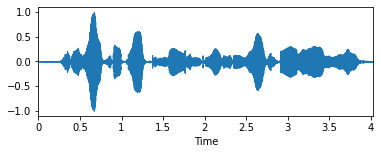

In [ ]:
import librosa.display
#check some parameters
yyy, sr = librosa.load('/content/DR1FCJF0SA1.WAV')
sr = 16000
print('length of first wav file: ', len(yyy))
print('sample rate: ', sr)
print('length of wav file in second: ', len(yyy)/sr)
print('N is: ', len(yyy)/sr*100)
x = librosa.feature.mfcc(y=yyy, sr=sr)
print('with default parameters: ', np.shape(x))
#n_mfcc is the number of coeficients in MFCC-feature extracting
x = librosa.feature.mfcc(y=yyy, sr=sr , n_mfcc=13, hop_length=160)
print('after tuning parameters: ', np.shape(x))
librosa.display.waveplot(yyy, sr=sr);

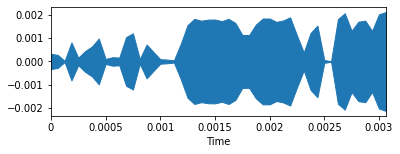

In [ ]:
librosa.display.waveplot(yyy[0:50], sr=sr);

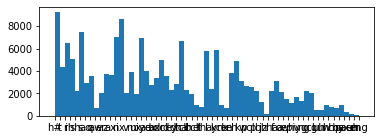

In [ ]:
plt.hist(trainPhonesLabels, 61);

In [ ]:
cq = 0
for i in trainPhonesLabels:
  if i == 'q':
    cq += 1

print(cq)

3590


##Labling the phones

\begin{array}{|c|c|c|c}\hline
\mathcal{\#} & \mathcal{Phone Class} & \mathcal{\# labels} & \mathcal{TIMIT labels} \\ \hline
  l1 & Vowel/Semivowel(VS) & 25 & aa \ ae \ ah \ ao \ aw \ ax \ axh \ axr \ ay \ eh \ er \ ey \ ih \ ix \ iy \ ow \ oy \ uh \ uw \ ux \ el \ l \ r \ w \ y \\ \hline
  l2 & Nasal/Flap(NF) & 8 & em \ en \ eng \ m \ n \ ng \ nx \ dx \\ \hline
  l3 & Strong Fracative(SF) & 6 & s \ z \ sh \ zh \ ch \ jh \\ \hline
  l4 & Weak Fricative(Wf) & 6 & v \ f \ dh \ th \ hh \ hv \\ \hline
  l5 & Stop(ST) & 6 & d \ b \ g \ p\ t\ k \\ \hline
  l6 & Closure (CL) & 9 & bcl \ dcl \ gcl \ pcl \ tcl \ kcl \ epi \ pau \ h\# \\ \hline \hline
  l7 & Sonorant(SON) & 33 & Vowel/Semivowel + Nasal/Flap \\ \hline
  l8 & Obstruent (OBS) & 18 & Strong Fric + Weak Fric + Stop\\ \hline
  l9 & Silence (SIL) & 9 & Same as Closure\\ \hline
  \end{array}

In [ ]:
phLabels1998 = {0: ['aa', 'ae', 'ah', 'ao', 'aw', 'ax', 'axh', 'axr', 'ay', 'eh', 
                'er', 'ey', 'ih', 'ix', 'iy', 'ow', 'oy', 'uh', 'uw', 'ux', 'el',
                 'l', 'r', 'w', 'y']
            ,1: ['em', 'en', 'eng', 'm', 'n', 'ng', 'nx', 'dx']
            ,2: ['s', 'z', 'sh', 'zh', 'ch', 'jh']
            ,3: ['v', 'f', 'dh', 'th', 'hh', 'hv']
            ,4: ['d', 'b', 'g', 'p', 't', 'k']
            ,5: ['bcl', 'dcl', 'gcl', 'pcl', 'tcl', 'kcl', 'epi', 'pau', 'h#']
            }

In [ ]:
# assigning the labels to one of 6 classes
# training data
trainPhoneLabelsConverted = np.zeros((trainNumbers), dtype=np.int)
cnt = 0
for label in trainPhonesLabels:
  for i in range(6):
    if label in phLabels1998[i]:
      trainPhoneLabelsConverted[cnt] = i
      cnt += 1
      break
print(set(trainPhoneLabelsConverted))

{0, 1, 2, 3, 4, 5}


In [ ]:
# test data
testPhoneLabelsConverted = np.zeros((testNumbers), dtype=np.int)
cnt = 0
for label in testPhonesLabels:
  for i in range(6):
    if label in phLabels1998[i]:
      testPhoneLabelsConverted[cnt] = i
      cnt += 1
      break
print(set(testPhoneLabelsConverted))

{0, 1, 2, 3, 4, 5}


In [ ]:
#preprocessing on mfcc_features stacking size - zero padding
cntTrain = 0
for ph in trainPhonesFeatures:
  cntTrain += np.size(ph, axis=1) // 7
  if np.size(ph, axis=1) % 7 != 0:
    cntTrain += 1

print(cntTrain)
# for instnace for len(ph) = 15 we have 3 frames of size 13*7 = 91

cntTest = 0
for ph in testPhonesFeatures:
  cntTest += np.size(ph, axis=1) // 7
  if np.size(ph, axis=1) % 7 != 0:
    cntTest += 1

print(cntTest)

277249
101012


In [ ]:
# we should have 277249 training data with dimention 299391*91
Xtr = np.zeros((cntTrain, 91))
ytr = np.zeros((cntTrain))
i = 0 # for counting train phones (transfering labels)
j = 0 # for counting splited training phones

for ph in trainPhonesFeatures:
  while np.size(ph, axis=1) >= 7:
    temp = ph[:, 0:7]
    Xtr[j] = temp.flat #adding first 7 columns to Xtrain as supervector
    ytr[j] = trainPhoneLabelsConverted[i]
    j += 1
    ph = np.delete(ph, range(7), axis=1)
  if np.size(ph, axis=1) > 3:
    temp = ph.flat
    Xtr[j, 0:len(temp)] = temp
    j += 1
  i += 1

In [ ]:
# we should have 101012 test data with dimention 299391*91
Xtst = np.zeros((cntTest, 91))
ytst = np.zeros((cntTest))
i = 0 # for counting test phones (transfering labels)
j = 0 # for counting splited test phones

for ph in testPhonesFeatures:
  while np.size(ph, axis=1) >= 7:
    temp = ph[:, 0:7]
    Xtst[j] = temp.flat #adding first 7 columns to Xtest as supervector
    ytst[j] = trainPhoneLabelsConverted[i]
    j += 1
    ph = np.delete(ph, range(7), axis=1)
  if np.size(ph, axis=1) > 3:
    temp = ph.flat
    Xtst[j, 0:len(temp)] = temp
    j += 1
  i += 1

In [ ]:
#one_hot the labels
nClasses = 6
ytrOneHot = tf.keras.utils.to_categorical(ytr, num_classes=nClasses, dtype='float32')

In [ ]:
#Data Normalizing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(Xtr)
Xtr = scaler.transform(Xtr)
Xtst = scaler.transform(Xtst)

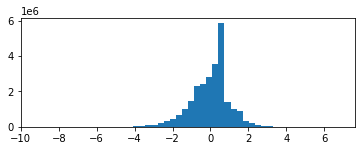

In [ ]:
#standardized MFCC features
plt.hist(Xtr.reshape(-1), bins=50);
#the dist is normal and doesn't need to clip

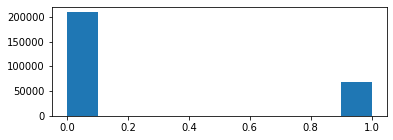

In [ ]:
# ytr_2class = (ytr != 0).astype(np.int)
# plt.hist(ytr_2class)
# ytst_2class = (ytst != 0).astype(np.int)

tf.Tensor([209497.  11819.  10997.   6794.  13521.  24621.], shape=(6,), dtype=float32)


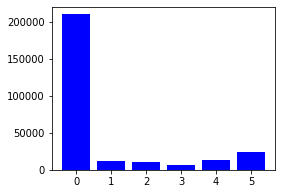

In [ ]:
one_hot_labels = np.array(ytrOneHot)
count_label = tf.reduce_sum(one_hot_labels, axis=0)
print(count_label) 
fig = plt.figure(figsize=(4, 3))
bar_width = 0.8
p1 = plt.bar(np.arange(6), count_label, bar_width, color='b', label='John')

In [ ]:
# from sklearn.svm import SVC
# ytr = ytr_2class
# ytst = ytst_2class
# classweight = {0: 1, 1: 3}
# svm = SVC(class_weight=classweight, kernel = 'linear')
# svm.fit(Xtr, ytr)
# ypredsvm = svm.predict(Xtst)
# print(classification_report(ytst, ypredsvm))

In [ ]:
# #smote for umsampling (Synthetic Minority Oversampling Technique)
# from imblearn.over_sampling import SMOTE
# # ytr = ytr_2class
# # ytst = ytst_2class
# # transform the dataset
# oversample = SMOTE()
# XtrU, ytrU = oversample.fit_resample(Xtr, ytr)
# # # define pipeline
# # over = SMOTE(sampling_strategy=0.1)
# # under = RandomUnderSampler(sampling_strategy=0.5)
# # steps = [('o', over), ('u', under)]
# # pipeline = Pipeline(steps=steps)

# from sklearn.tree import DecisionTreeClassifier
# # the deeper tree, the more probable to get overfitted
# clf = DecisionTreeClassifier(random_state=0, max_depth=7)
# clf = clf.fit(XtrU, ytrU)

# ypredtree = clf.predict(Xtst)
# print(classification_report(ytst, ypredtree))

In [ ]:
# plt.hist(ytrU)

##Biulding the Network

In [ ]:
# !pip install keras-balanced-batch-generator
# keras-balanced-batch-generator
# URL: https://github.com/soroushj/keras-balanced-batch-generator
# from keras_balanced_batch_generator import make_generator
# generator = make_generator(Xtr, ytrOneHot, batch_size=32)

In [ ]:
#Data Balancing
# from imblearn.keras import balanced_batch_generator
# from imblearn.under_sampling import NearMiss
# training_generator, steps_per_epoch = balanced_batch_generator(
#     Xtr, ytrOneHot, sampler=NearMiss(), batch_size=10, random_state=42)


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

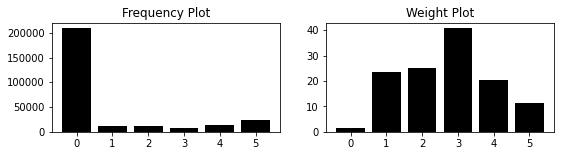

class0 : numbers is 209497 so its weight is 1
class1 : numbers is 11819 so its weight is 23
class2 : numbers is 10997 so its weight is 25
class3 : numbers is 6794 so its weight is 41
class4 : numbers is 13521 so its weight is 21
class5 : numbers is 24621 so its weight is 11


In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
classCounts = np.histogram(ytr, bins=len(set(ytr)))[0]
total = len(ytr)
weight_for_0 = (1 / classCounts[0])*(total)
weight_for_1 = (1 / classCounts[1])*(total)
weight_for_2 = (1 / classCounts[2])*(total)
weight_for_3 = (1 / classCounts[3])*(total)
weight_for_4 = (1 / classCounts[4])*(total)
weight_for_5 = (1 / classCounts[5])*(total)

class_weight = {0: weight_for_0, 1: weight_for_1,
                2: weight_for_2, 3: weight_for_3,
                4: weight_for_4, 5: weight_for_5}


fig = plt.figure(figsize=(9, 2))
ax1 = fig.add_subplot(121)
p1 = plt.bar(np.arange(6), count_label, bar_width,
             color='black', label='John')
ax2 = fig.add_subplot(122)
array = np.array(list(class_weight.items()), dtype=np.float32)[:,1]
plt.bar(range(0, 6), array, color='black')
ax1.title.set_text('Frequency Plot')
ax2.title.set_text('Weight Plot')
plt.show()

for i in range(6):
  print('class' + str(i) + ' : ' + 
        'numbers is ' + str(int(count_label.numpy()[i])) +
        ' so its weight is ' + str(round(class_weight[i])))

In [ ]:
def build_neural_network(data_size_in, n_classes, output_bias=None):
    #imbalanced handling
    if output_bias is not None:
      output_bias = tf.keras.initializers.Constant(output_bias)
    # He is more compatible with relu and Glorot is more adjustable with tanh
    initializer = tf.keras.initializers.HeUniform()

    inputs = layers.Input(shape=data_size_in)

    x = layers.Conv1D(16, kernel_size=5, activation='relu', kernel_initializer=initializer)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.MaxPool1D(pool_size=2)(x)
    x = layers.Conv1D(32, kernel_size=5, activation='relu', kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.MaxPool1D(pool_size=2)(x)
    x = layers.Conv1D(64, kernel_size=5, activation='relu', kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.MaxPool1D(pool_size=2)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(32, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dropout(0.5)(x)
    prediction = layers.Dense(n_classes, activation='softmax', bias_initializer=output_bias)(x)

    model = Model(inputs=inputs, outputs=prediction)
    print(model.summary())
    
    return model

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
#compile the model
data_size_in = (91, 1)   #13*7
n_classes = 6   #we have 6 different labels
ls = 'CategoricalCrossentropy'
opt = optimizers.Adam(learning_rate=0.01, beta_1=0.92)

network = build_neural_network(data_size_in, n_classes)
network.compile(loss=ls, optimizer=opt, metrics=METRICS)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 91, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 87, 16)            96        
_________________________________________________________________
batch_normalization (BatchNo (None, 87, 16)            64        
_________________________________________________________________
dropout (Dropout)            (None, 87, 16)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 43, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 39, 32)            2592      
_________________________________________________________________
batch_normalization_1 (Batch (None, 39, 32)            128   

Epoch 1/10
24953/24953 [==============================] - 251s 9ms/step - loss: 10.6055 - tp: 58826.9038 - fp: 548.6236 - tn: 623326.3720 - fn: 65948.0953 - accuracy: 0.9089 - precision: 0.9822 - recall: 0.4614 - auc: 0.8072 - prc: 0.6455 - val_loss: 0.0000e+00 - val_tp: 27725.0000 - val_fp: 0.0000e+00 - val_tn: 138625.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 2/10
24953/24953 [==============================] - 215s 9ms/step - loss: 10.5788 - tp: 59589.3455 - fp: 132.8633 - tn: 623742.1323 - fn: 65185.6536 - accuracy: 0.9123 - precision: 0.9979 - recall: 0.4747 - auc: 0.8100 - prc: 0.6504 - val_loss: 0.0000e+00 - val_tp: 27725.0000 - val_fp: 0.0000e+00 - val_tn: 138625.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 3/10
24953/24953 [==============================] - 215s 9ms/step - loss: 10.8465 - tp: 6066

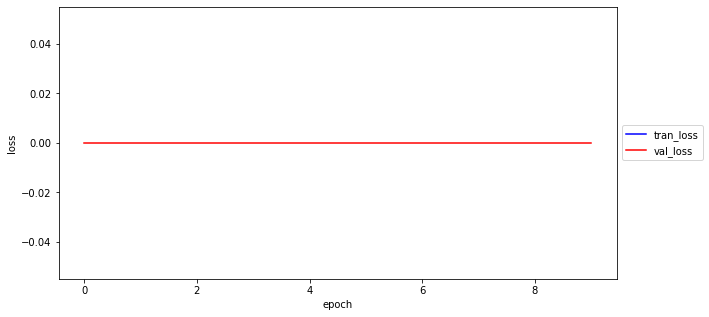

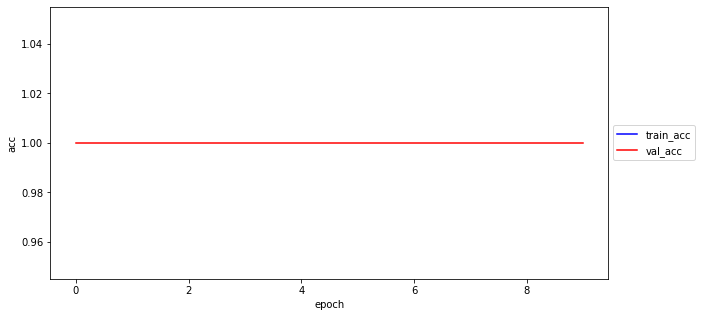

In [ ]:
#feed the network
# lists where we will be storing values during training, for visualization purposes
traLosses = [] # list for training loss
traAccs = [] # list for training accuracy
valLosses = [] # list for validation loss
valAccs = [] # list for validation accuracy
batchSize = 10
nEpochs = 10

# Train your network
results = network.fit(Xtr, ytrOneHot, 
                      batch_size=batchSize, 
                      validation_split=0.2, 
                      epochs = nEpochs, verbose = 1,
                      callbacks=[early_stopping],
                      # The class weights go here
                      class_weight=class_weight)
# callback_history = network.fit(training_generator,
#                              steps_per_epoch=steps_per_epoch,
#                              epochs=10, verbose=1)


# Get training loss and accuracy
# traLosses = callback_history.history['loss']
# traAccs = callback_history.history['accuracy']
valLosses = results.history['val_loss']
valAccs = results.history['val_accuracy']

# Visualization of the learning curves
fig = plt.figure(figsize=(10, 5))
plt.plot(range(len(traLosses)), traLosses, 'b')
plt.plot(range(len(valLosses)), valLosses, 'r')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend({"tran_loss", "val_loss"}, 
          loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

fig = plt.figure(figsize=(10, 5))
plt.plot(range(len(traAccs)), traAccs, 'b')
plt.plot(range(len(valAccs)), valAccs, 'r')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend({"train_acc", "val_acc"}, 
          loc='center left', bbox_to_anchor=(1, 0.5))
# display.display(plt.gcf())

In [ ]:
#prediction phase
yPred = network.predict(Xtst)
yPred = np.argmax(yPred, axis=1)

In [ ]:
print(classification_report(ytst, yPred))

              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86     75701
         1.0       0.00      0.00      0.00      4454
         2.0       0.00      0.00      0.00      4081
         3.0       0.00      0.00      0.00      2563
         4.0       0.00      0.00      0.00      4962
         5.0       0.00      0.00      0.00      9251

    accuracy                           0.75    101012
   macro avg       0.12      0.17      0.14    101012
weighted avg       0.56      0.75      0.64    101012



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(confusion_matrix(ytst, yPred))
yPred[0]

[[75701     0     0     0     0     0]
 [ 4454     0     0     0     0     0]
 [ 4081     0     0     0     0     0]
 [ 2563     0     0     0     0     0]
 [ 4962     0     0     0     0     0]
 [ 9251     0     0     0     0     0]]


0

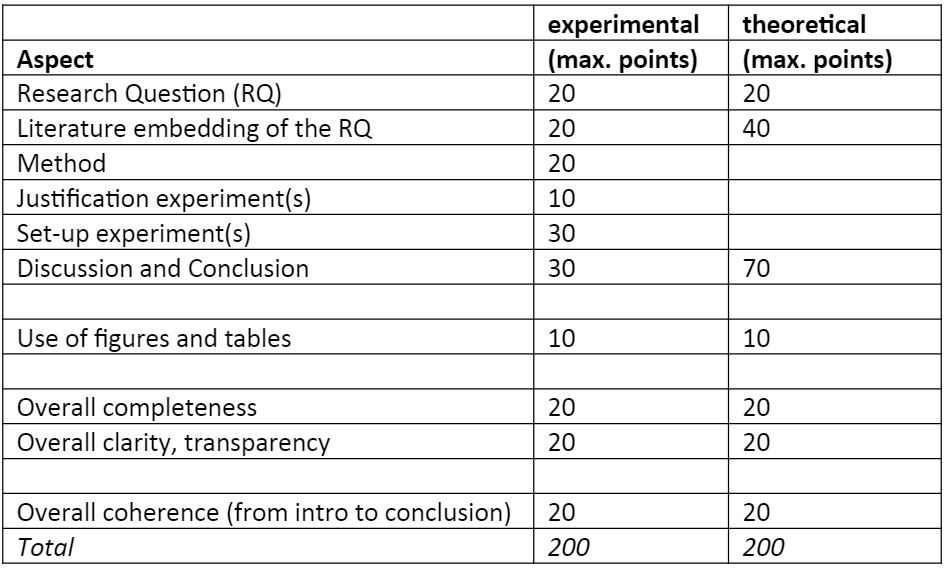